<a href="https://colab.research.google.com/github/mzsolt68/DogVision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification (v2)

Building an end-to-end multi-class image classifier using TensorFlow

## 1. Problem

Identifying the breed of a dog from a given image

## 2. Data

We're going to use the Stanford Dogs dataset, which is available from several sources:
* The original project website: http://vision.stanford.edu/aditya86/ImageNetDogs/
* Inside the Tensorflow datasets: https://www.tensorflow.org/datasets/catalog/stanford_dogs
* On Kaggle: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

## 3. Using the data

To make sure we don't have to download the data every time we come back to Colab:
* Download the data to the attached Google Drive if it doesn't already exists
* Copy the data to the Google drive if it isn't already there
* If the data already exists on Google Drive We'll import it

## 4. Features

Some information about the data:
* We are dealing with unstructured data (images), so it is probably best we use deeep learning/transfer learning.
* There are 120 breeds of dogs, this means there are 120 different classes).
* Around 10,000+ images in the training set (these images have labels)
* Around 10,000+ images in the test set


In [1]:
# Quick timestamp
import datetime
print(f"Notebook last run: {datetime.datetime.now()}")

Notebook last run: 2025-05-11 15:26:18.489551


In [2]:
# Import TensorFlow and check if we have GPU access
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

device_list = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in device_list]:
  print(f"[INFO] TensorFlow has GPU available to use.")
  print(f"[INFO] Accessible devices:\n{device_list}")
else:
  print(f"[INFO] TensorFlow does not have GPU available to use. Models may take a while to train.")
  print(f"[INFO] Accessible devices:\n{device_list}")

TensorFlow version: 2.18.0
[INFO] TensorFlow has GPU available to use.
[INFO] Accessible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Getting the data
Check if the target files exist in Google Drive and copy them to Colab. If the files doesn't exist, download them.

In [3]:
from pathlib import Path
from google.colab import drive

# 1. Mount Google Drive (this will bring up a pop-up to sign-in/authenticate)
# Note: This step is specifically for Google Colab, if you're working locally, you may need a different setup
# drive.mount("/content/drive")

# 2. Setup constants
# Note: For constants like this, you'll often see them created as variables with all capitals
TARGET_DRIVE_PATH = Path("drive/MyDrive/Dog_Vision/Data")
TARGET_FILES = ["images.tar", "annotation.tar", "lists.tar"]
TARGET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs"

# 3. Setup local path
local_dir = Path("dog_vision_data")

# 4. Check if the target files exist in Google Drive, if so, copy them to Google Colab
if all((TARGET_DRIVE_PATH / file).is_file() for file in TARGET_FILES):
  print(f"[INFO] Copying Dog Vision files from Google Drive to local directory...")
  print(f"[INFO] Source dir: {TARGET_DRIVE_PATH} -> Target dir: {local_dir}")
  !cp -r {TARGET_DRIVE_PATH} {local_dir}
  print("[INFO] Good to go!")

else:
  # 5. If the files don't exist in Google Drive, download them
  print(f"[INFO] Target files not found in Google Drive.")
  print(f"[INFO] Downloading the target files... this shouldn't take too long...")
  for file in TARGET_FILES:
    # wget is short for "world wide web get", as in "get a file from the web"
    # -nc or --no-clobber = don't download files that already exist locally
    # -P = save the target file to a specified prefix, in our case, local_dir
    !wget -nc {TARGET_URL}/{file} -P {local_dir} # the "!" means to execute the command on the command line rather than in Python

  print(f"[INFO] Saving the target files to Google Drive, so they can be loaded later...")

  # 6. Ensure target directory in Google Drive exists
  TARGET_DRIVE_PATH.mkdir(parents=True, exist_ok=True)

  # 7. Copy downloaded files to Google Drive (so we can use them later and not have to re-download them)
  !cp -r {local_dir}/* {TARGET_DRIVE_PATH}/

[INFO] Copying Dog Vision files from Google Drive to local directory...
[INFO] Source dir: drive/MyDrive/Dog_Vision/Data -> Target dir: dog_vision_data
[INFO] Good to go!


In [4]:
# Make sure the files are exist
if local_dir.exists():
  print(str(local_dir) + "/")
  for item in local_dir.iterdir():
    print("  ", item.name)

dog_vision_data/
   annotation.tar
   lists.tar
   images.tar


In [5]:
# Untar the images, notes/tags
!tar -xf {local_dir}/images.tar -C {local_dir}
!tar -xf {local_dir}/annotation.tar -C {local_dir}
!tar -xf {local_dir}/lists.tar -C {local_dir}


We've got some new files.
Specifically:

* `train_list.mat` - a list of all the training set images.
* `test_list.mat` - a list of all the testing set images.
* `Images/` - a folder containing all of the images of dogs.
* `Annotation/` - a folder containing all of the annotations for each image.
* `file_list.mat` - a list of all the files (training and test list combined).


### Exploring the data
Before we build a model, it's good to explore the data to see what kind of data we're working with. For example:
* **Check at least 100+ random samples** if you have a large dataset.
* **Visualize!**
* **Check the distribution and other statistics.** How many samples are there? In a classification problem, how many classes and labels per class are there? etc.

#### Exploring the files lists

In [6]:
# Open the MATLAB files
import scipy

# Open lists of train and test .mat
train_list = scipy.io.loadmat(Path(local_dir, "train_list.mat"))
test_list = scipy.io.loadmat(Path(local_dir, "test_list.mat"))
file_list = scipy.io.loadmat(Path(local_dir, "file_list.mat"))

# Let's inspect the output and type of the train_list
train_list, type(train_list)

({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:36:13 2011',
  '__version__': '1.0',
  '__globals__': [],
  'file_list': array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
        dtype=object),
  'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_5927'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_4441'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_1502'], dtype='<U34')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754'], dtype=

In [7]:
# Check out the keys of the train_list dictionary
train_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [8]:
# Check the length of the file_list key
print(f"Number of files in training list: {len(train_list['file_list'])}")
print(f"Number of files in testing list: {len(test_list['file_list'])}")
print(f"Number of files in full list: {len(file_list['file_list'])}")

Number of files in training list: 12000
Number of files in testing list: 8580
Number of files in full list: 20580


We have 20580 images total splitted in 60/40 ratio between train and test.

In [9]:
# Inspect the file_list key more
train_list['file_list']


array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
      dtype=object)

In [10]:
# Get a single filename
train_list['file_list'][0][0][0]

np.str_('n02085620-Chihuahua/n02085620_5927.jpg')

In [11]:
# Get a Python list of all file names for each list
train_file_list = list([item[0][0] for item in train_list["file_list"]])
test_file_list = list([item[0][0] for item in test_list["file_list"]])
full_file_list = list([item[0][0] for item in file_list["file_list"]])

len(train_file_list), len(test_file_list), len(full_file_list)

(12000, 8580, 20580)

In [12]:
# Get some random samples
import random

random.sample(train_file_list, k=10)

[np.str_('n02102318-cocker_spaniel/n02102318_89.jpg'),
 np.str_('n02113712-miniature_poodle/n02113712_2107.jpg'),
 np.str_('n02102040-English_springer/n02102040_5133.jpg'),
 np.str_('n02095570-Lakeland_terrier/n02095570_1372.jpg'),
 np.str_('n02092339-Weimaraner/n02092339_669.jpg'),
 np.str_('n02094114-Norfolk_terrier/n02094114_694.jpg'),
 np.str_('n02104029-kuvasz/n02104029_2467.jpg'),
 np.str_('n02086240-Shih-Tzu/n02086240_4346.jpg'),
 np.str_('n02086240-Shih-Tzu/n02086240_1205.jpg'),
 np.str_('n02101388-Brittany_spaniel/n02101388_183.jpg')]

Make sure that the training set and the test set doesn't have common items

In [13]:
# How many files in the training set intersect with the testing set?
len(set(train_file_list).intersection(test_file_list))

0

#### Exploring the Annotation folder

In [14]:
import os

os.listdir(f"{local_dir}/Annotation")[:10]

['n02091244-Ibizan_hound',
 'n02109961-Eskimo_dog',
 'n02099429-curly-coated_retriever',
 'n02101388-Brittany_spaniel',
 'n02102177-Welsh_springer_spaniel',
 'n02093256-Staffordshire_bullterrier',
 'n02098286-West_Highland_white_terrier',
 'n02100735-English_setter',
 'n02102973-Irish_water_spaniel',
 'n02095889-Sealyham_terrier']

There are directories with dog breed names with several numbered files inside.
Each of the numbered files contains a HTML version.
For example, `Annotation/n02085620-Chihuahua/n02085620_10074`:

```
<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>
```

The fields include the name and the size of the image, the label of the object, and where it is insid ethe image (bounding box).

Write a function to check the number of subfolders inside the `Annotation` folder (there should be 120 subfolder, one for each dog breed).

In [15]:
from pathlib import Path

def count_subfolders(path: str) -> int:
  """
    Count the number of subfolders in a given directory.

    Args:
    path (str): The path to the directory in which to count subfolders.

    Returns:
    int: The number of subfolders in the specified directory.

    Examples:
    >>> count_subfolders('/path/to/directory')
    3  # if there are 3 subfolders in the specified directory
  """
  return len([item for item in Path(path).iterdir() if item.is_dir()])

annotation_path = f"{local_dir}/Annotation"
folder_count = count_subfolders(annotation_path)
print(f"Number of subfolders in {annotation_path}: {folder_count}")

Number of subfolders in dog_vision_data/Annotation: 120


There are 120 subfolder of annotations, one for each class of dog.

But it looks like the class names are already in the filepaths.

In [16]:
# View a single training file pathname
train_file_list[0]

np.str_('n02085620-Chihuahua/n02085620_5927.jpg')

So we know, that image `n02085620_5927.jpg` should contain a `Chihuahua`.
Let's check.

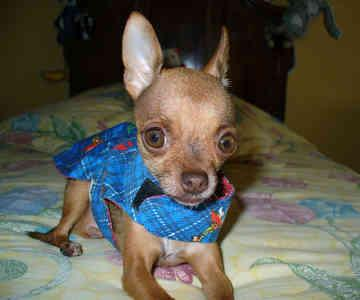

In [17]:
from IPython.display import Image
Image(Path(f"{local_dir}/Images/", train_file_list[0]))

#### Exploring the Images folder

We know that the image file names come in the format `class_name/image_name`, for example, `n02085620-Chihuahua/n02085620_5927.jpg`.

To make things a little simpler, let's create the following:

1. A mapping from folder name -> class name in dictionary form, for example, `{'n02113712-miniature_poodle': 'miniature_poodle',  'n02092339-Weimaraner': 'weimaraner',  'n02093991-Irish_terrier': 'irish_terrier'...}`. This will help us when visualizing our data from its original folder.
2. A list of all unique dog class names with simple formatting, for example, `['affenpinscher',  'afghan_hound',  'african_hunting_dog',  'airedale',  'american_staffordshire_terrier'...]`.


In [18]:
# Get a list of all image folders
image_folders = os.listdir(f"{local_dir}/Images")
image_folders[:10]

['n02091244-Ibizan_hound',
 'n02109961-Eskimo_dog',
 'n02099429-curly-coated_retriever',
 'n02101388-Brittany_spaniel',
 'n02102177-Welsh_springer_spaniel',
 'n02093256-Staffordshire_bullterrier',
 'n02098286-West_Highland_white_terrier',
 'n02100735-English_setter',
 'n02102973-Irish_water_spaniel',
 'n02095889-Sealyham_terrier']

In [19]:
# Create a foldername -> class name dictionary
folder_to_class_dictionary = {}
for folder_name in image_folders:
  class_name = folder_name.split("-")[1].lower().replace("_", " ")
  folder_to_class_dictionary[folder_name] = class_name

# Make sure there are 120 entries in the dictionary
assert len(folder_to_class_dictionary) == 120

In [20]:
list(folder_to_class_dictionary.items())[:10]

[('n02091244-Ibizan_hound', 'ibizan hound'),
 ('n02109961-Eskimo_dog', 'eskimo dog'),
 ('n02099429-curly-coated_retriever', 'curly'),
 ('n02101388-Brittany_spaniel', 'brittany spaniel'),
 ('n02102177-Welsh_springer_spaniel', 'welsh springer spaniel'),
 ('n02093256-Staffordshire_bullterrier', 'staffordshire bullterrier'),
 ('n02098286-West_Highland_white_terrier', 'west highland white terrier'),
 ('n02100735-English_setter', 'english setter'),
 ('n02102973-Irish_water_spaniel', 'irish water spaniel'),
 ('n02095889-Sealyham_terrier', 'sealyham terrier')]

In [21]:
# Get a list of unique dog names
dog_names = sorted(list(set(folder_to_class_dictionary.values())))
dog_names[:10]

['affenpinscher',
 'afghan hound',
 'african hunting dog',
 'airedale',
 'american staffordshire terrier',
 'appenzeller',
 'australian terrier',
 'basenji',
 'basset',
 'beagle']

Now we've got:
- a mapping from a folder name to a class name: `folder_to_class_dictionary`
- a list of unique dog breeds: `dog_names`

#### Visualize a group of random images

Create a function that takes a list of image paths and randomly selects 10 paths to display.
The function will:
1. Take a list of image paths as input.
2. Creat a grid of Matplotlib plots (e.g. 2x5)
3. Using `random.sample()`, selects 10 image paths from the input list.
4. Iterate through the flattened axes via `axes.flat` which is a reference to the attribute `numpy.ndarray.flat`.
5. Extract the sample path from the list of samples.
6. Get the sample title from the parent folder of the path using `Path.parent.stem` and then extract the formatted dog breed name by indexing `folder_to_class_name_dict`.
7. Read the image with `plt.imread()` and show it on the target ax with `ax.imshow()`.
8. Set the title of the plot to the parent folder name with `ax.set_title()` and turn the axis marks of with `ax.axis("off")` (this makes for pretty plots).
9. Show the plot with `plt.show()`.

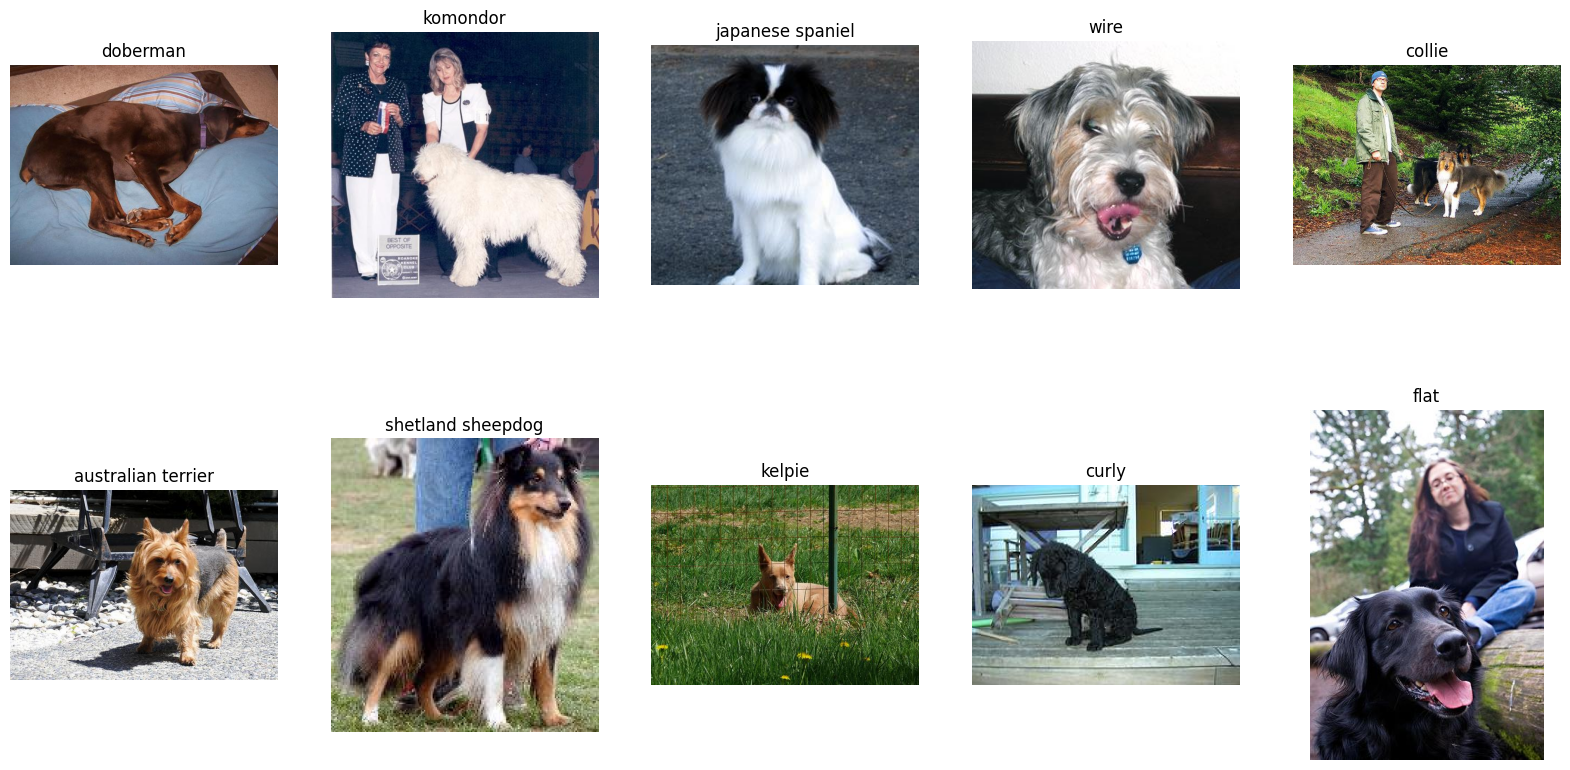

In [22]:
import random
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt

def plot_10_random_images(image_paths: List[Path], extract_title: bool = True) -> None:
  """
    Plots 10 random images from a list of image paths.

    Args:
    image_paths (List[Path]): A list of image paths to plot.
    extract_title (bool): Whether to extract the title from the image path

    Returns:
    None
  """
  # Setup a grid of plots
  fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))

  # Get a list of random image paths
  samples = random.sample(image_paths, k=10)

  # Iterate through the flattened axes and corresponding image paths
  for i, ax in enumerate(axes.flat):
    # Get the image path
    image_path = samples[i]
    # Extract the parent directory name to use as the title (if neccesary)
    if extract_title:
      title = folder_to_class_dictionary[image_path.parent.stem]
    else:
      title = image_path.parent.stem

    # Read the image
    ax.imshow(plt.imread(image_path))
    # Set the title
    ax.set_title(title)
    # Turn the axis off
    ax.axis("off")

  # Show the plot
  plt.show()

plot_10_random_images(image_paths=[Path(f"{local_dir}/Images/") / path for path in train_file_list])


#### Exploring the distribution of the data

How many images of dog we have per breed?

A balanced distribution would mean, we have roughly the same number of images of every breed (e.g. 100 images per breed)

Let's see, how many images we have per breed? Write e function, that counts the images in a given directory:

1. Take in a target directory/folder.
2. Create a list of all the subdirectories/subfolders in the target folder.
3. Create an empty list, `image_class_counts` to append subfolders and their counts to.
4. Iterate through all of the subdirectories.
5. Get the class name of the target folder as the name of the folder.
6. Count the number of images in the target folder using the length of the list of image paths (we can get these with `Path().rglob(*.jpg)` where `*.jpg` means "all files with the extension `.jpg`".
7. Append a dictionary of `{"class_name": class_name, "image_count": image_count}` to the `image_class_counts` list (we create a list of dictionaries so we can turn this into a pandas DataFrame).
8. Return the `image_class_counts` list.

In [23]:
# Create a dictionary of image counts
from pathlib import Path
from typing import List, Dict

def count_images_in_subfolders(target_dir: str) -> List[Dict[str, int]]:
  """
    Counts the number of JPEG images in each subfolder in a given directory.
    Each subdirectory is assumed to represent a class, and the function counts
    the number of '.jpg' files within each one. The result is a list of
    dictionaries with the class name and corresponding image count.

    Args:
    target_dir (str): The path to the directory in which to count

    Returns:
    List[Dict[str, int]]: A list of dictionaries with 'class_name' and 'image_count' for each subdirectory.

    Examples:
        >>> count_images_in_subdirs('/path/to/directory')
        [{'class_name': 'beagle', 'image_count': 50}, {'class_name': 'poodle', 'image_count': 60}]
  """
  # Create a list of all the subfolders in the target directory
  image_dir = Path(target_dir)
  subfolders = [folder for folder in image_dir.iterdir() if folder.is_dir()]

  # Create an empty list to append image counts
  image_class_counts = []

  # Iterate through all of the subfolders
  for subfolder in subfolders:
    # Get the class name of the target folder as the name of the folder
    class_name = subfolder.name

    # Count the number of images in the target folder
    image_count = len(list(subfolder.rglob("*.jpg")))

    # Append a dictionary of class name and image count to count list
    image_class_counts.append({"class_name": class_name, "image_count": image_count})

  # Return the count list
  return image_class_counts


Run the function on the target directory and view the first few indexes

In [24]:
image_class_counts = count_images_in_subfolders(f"{local_dir}/Images")
image_class_counts[:10]

[{'class_name': 'n02091244-Ibizan_hound', 'image_count': 188},
 {'class_name': 'n02109961-Eskimo_dog', 'image_count': 150},
 {'class_name': 'n02099429-curly-coated_retriever', 'image_count': 151},
 {'class_name': 'n02101388-Brittany_spaniel', 'image_count': 152},
 {'class_name': 'n02102177-Welsh_springer_spaniel', 'image_count': 150},
 {'class_name': 'n02093256-Staffordshire_bullterrier', 'image_count': 155},
 {'class_name': 'n02098286-West_Highland_white_terrier', 'image_count': 169},
 {'class_name': 'n02100735-English_setter', 'image_count': 161},
 {'class_name': 'n02102973-Irish_water_spaniel', 'image_count': 150},
 {'class_name': 'n02095889-Sealyham_terrier', 'image_count': 202}]

Turn the `image_class_count` variable to a pandas `DataFrame`.

Sort the `DataFrame` by `image_count`.

In [25]:
import pandas as pd

image_counts_dataframe = pd.DataFrame(image_class_counts).sort_values("image_count", ascending=False)
image_counts_dataframe.head()

,class_name,image_count
37,n02085936-Maltese_dog,252
40,n02088094-Afghan_hound,239
34,n02092002-Scottish_deerhound,232
94,n02112018-Pomeranian,219
87,n02111889-Samoyed,218


Map the `class_name` column to the `folder_to_class_dictionary` to easier read.

In [26]:
image_counts_dataframe["class_name"] = image_counts_dataframe["class_name"].map(folder_to_class_dictionary)
image_counts_dataframe.head()

,class_name,image_count
37,maltese dog,252
40,afghan hound,239
34,scottish deerhound,232
94,pomeranian,219
87,samoyed,218


Let's visualize the distribution of the data by turning the DataFrame into a plot.

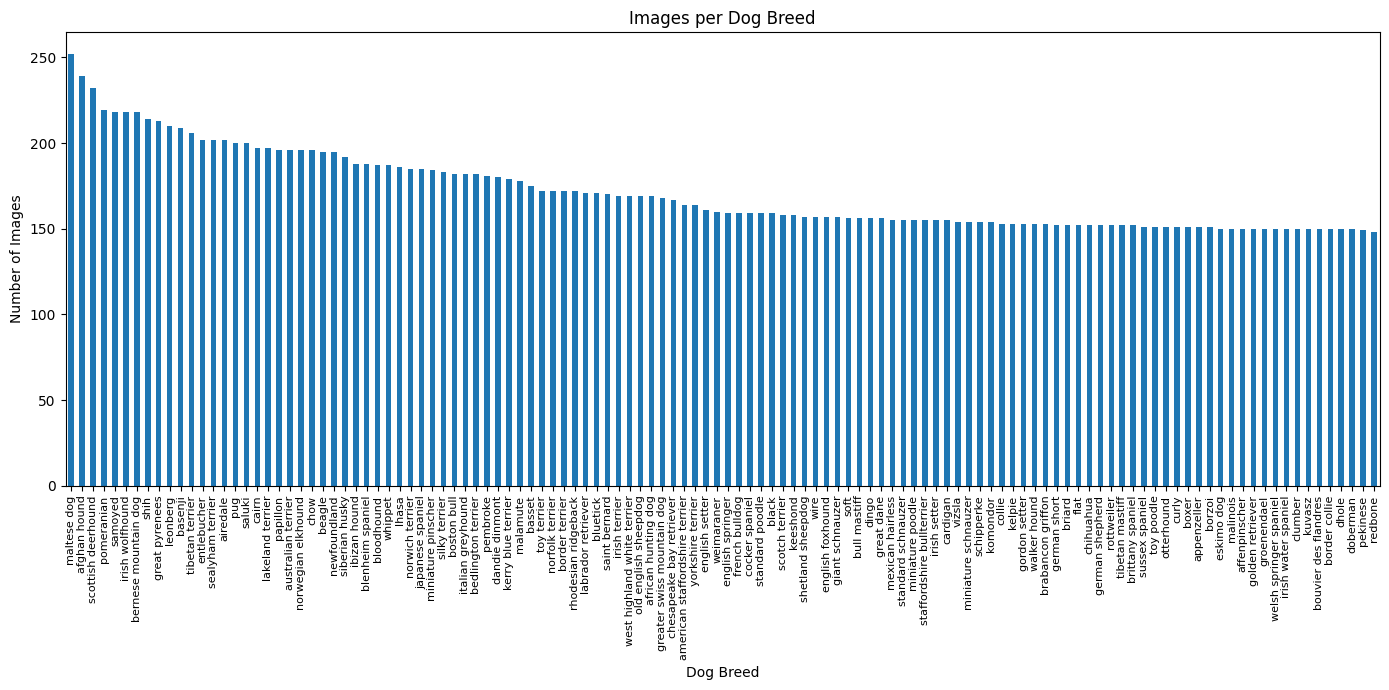

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
image_counts_dataframe.plot(kind="bar",
                            x="class_name",
                            y="image_count",
                            legend=False,
                            ax=plt.gca())
plt.title("Images per Dog Breed")
plt.xlabel("Dog Breed")
plt.ylabel("Number of Images")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [28]:
# Get some statistics about the DataFrame
image_counts_dataframe.describe()

,image_count
count,120.000000
mean,171.500000
std,23.220898
min,148.000000
25%,152.750000
50%,159.500000
75%,186.250000
max,252.000000


### Creating training and test data split directories

After exploring the data, we need to create a training and test data splits. The original dataset already comes with this split, so we stick with these. But we also creating a smaller training set (about 10% of the original training set) for faster experimentation.

We create:

- a folder for training images `dog_vision_data/images/train`
- a folder for test images `dog_vision_data/images/test`
- inside each directory, make directories for each dog breed

In [29]:
from pathlib import Path

# Target directory for image splits
image_split_directory = Path(local_dir, "images_split")

# Training and test directories
train_dir = image_split_directory / "train"
test_dir = image_split_directory / "test"

# Create the target directories if it doesn't exist
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)
print(f"Directory {train_dir} is exists.")
print(f"Directory {test_dir} is exists.")

# Make folders for each dog breeds
for dog_name in dog_names:
  # Make training folder
  dog_train_dir = train_dir / dog_name
  dog_train_dir.mkdir(parents=True, exist_ok=True)

  # Make test folder
  dog_test_dir = test_dir / dog_name
  dog_test_dir.mkdir(parents=True, exist_ok=True)

# Check if 120 subfolder in each folder
assert count_subfolders(train_dir) == len(dog_names)
assert count_subfolders(test_dir) == len(dog_names)

Directory dog_vision_data/images_split/train is exists.
Directory dog_vision_data/images_split/test is exists.


In [30]:
# See the first 10 directories in the training directory
sorted([str(dir_name) for dir_name in train_dir.iterdir() if dir_name.is_dir()])[:10]

['dog_vision_data/images_split/train/affenpinscher',
 'dog_vision_data/images_split/train/afghan hound',
 'dog_vision_data/images_split/train/african hunting dog',
 'dog_vision_data/images_split/train/airedale',
 'dog_vision_data/images_split/train/american staffordshire terrier',
 'dog_vision_data/images_split/train/appenzeller',
 'dog_vision_data/images_split/train/australian terrier',
 'dog_vision_data/images_split/train/basenji',
 'dog_vision_data/images_split/train/basset',
 'dog_vision_data/images_split/train/beagle']

Create a function which will copy images from the `Images` folder into the respective directories inside `images_split/train` and `images_split/test`

Specifically:

1. Take in a list of source files to copy (e.g. `train_file_list`) and a target directory to copy files to.
2. Iterate through the list of sources files to copy (use `tqdm` which comes installed with Google Colab to create a progress bar of how many files have been copied).
3. Convert the source file path to a `Path` object.
4. Split the source file path and create a `Path` object for the destination folder (e.g. "n02112018-Pomeranian" -> "pomeranian").
5. Get the target file name (e.g. "n02112018-Pomeranian/n02112018_6208.jpg" -> "n02112018_6208.jpg").
6. Create a destination path for the source file to be copied to (e.g. `images_split/train/pomeranian/n02112018_6208.jpg`).
7. Ensure the destination directory exists, similar to the step we took in the previous section (you can't copy files to a directory that doesn't exist).
8. Print out the progress of copying (if necessary).
9. Copy the source file to the destination using Python's `shutil.copy2(src, dst)`.

In [31]:
from pathlib import Path
from shutil import copy2
from tqdm.auto import tqdm

def copy_files_to_target_directory(file_list: List[str],
                                   target_dir: str,
                                   images_dir: str = "dog_vision_data/Images",
                                   verbose: bool = False) -> None:
  """
  Copies a list of files from the images directory to a target directory.

  Parameters:
  file_list (list[str]): A list of file paths to copy.
  target_dir (str): The destination directory path where files will be copied.
  images_dir (str, optional): The directory path where the images are currently stored. Defaults to 'dog_vision_data/Images'.
  verbose (bool, optional): If set to True, the function will print out the file paths as they are being copied. Defaults to False.

  Returns:
  None
  """
  # Iterate through source files
  for file in tqdm(file_list):
    # Convert file path to Path object
    source_file_path = Path(images_dir) / Path(file)

    # Split the file path and create a Path object for destination folder
    file_class_name = folder_to_class_dictionary[Path(file).parts[0]]

    # Get the name of the image
    file_image_name = Path(file).name

    # Create destination path
    destination_path = Path(target_dir) / file_class_name / file_image_name

    # Check if destination directory exists
    destination_path.parent.mkdir(parents=True, exist_ok=True)

    # Print out copy message, if neccesary
    if verbose:
      print(f"[INFO] Copying: {source_file_path} to {destination_path}")

    # Copy the file to the destination
    copy2(source_file_path, destination_path)

Test the copy function by copying files from `train_file_list` to `train_dir`

In [32]:
copy_files_to_target_directory(file_list=train_file_list,
                               target_dir=train_dir,
                               verbose=False)

  0%|          | 0/12000 [00:00<?, ?it/s]

Copy files from `test_file_list` to `test_dir`

In [33]:
copy_files_to_target_directory(file_list=test_file_list,
                               target_dir=test_dir,
                               verbose=False)

  0%|          | 0/8580 [00:00<?, ?it/s]

Check if the number of files in the `train_file_list` is the same as the number of images in the `train_dir` (and also check the test files).

In [34]:
# Get a list of all .jpg file paths in train and test image folders
train_image_paths = list(train_dir.rglob("*.jpg"))
test_image_paths = list(test_dir.rglob("*.jpg"))

# Make sure the number of images in the train and test directories equals the number of files in the original lists
assert len(train_image_paths) == len(train_file_list)
assert len(test_image_paths) == len(test_file_list)

print(f"Number of images in {train_dir}: {len(train_image_paths)}")
print(f"Number of images in {test_dir}: {len(test_image_paths)}")

Number of images in dog_vision_data/images_split/train: 12000
Number of images in dog_vision_data/images_split/test: 8580


Plot some random images from the `train_image_path`

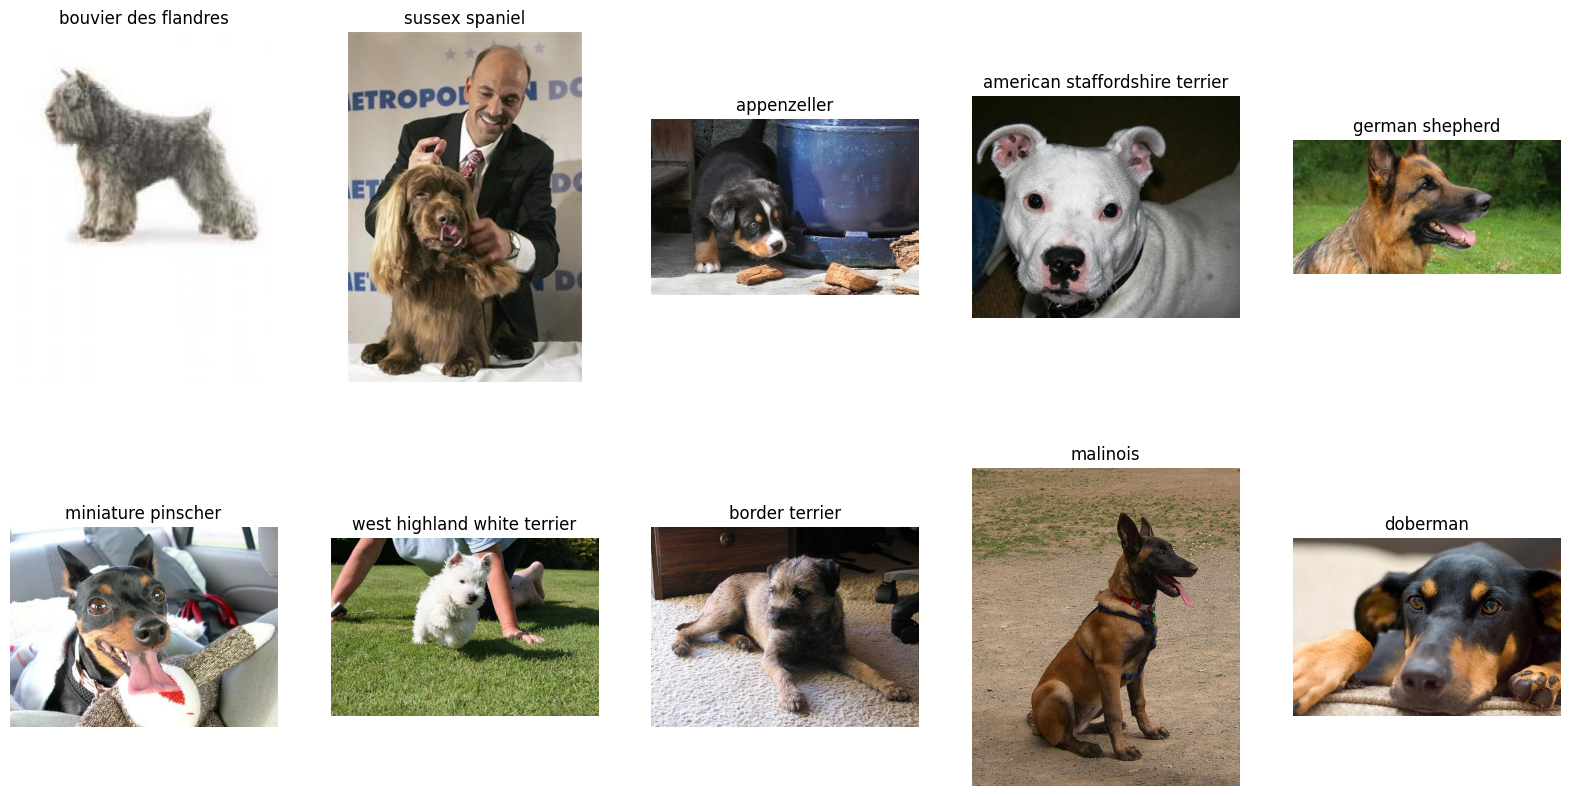

In [35]:
plot_10_random_images(image_paths=train_image_paths,
                      extract_title=False)

#### Create a 10% training dataset split

To make model experiments faster, we create a smaller (~10%) training dataset in the `images_split` directory.
To make this dataset, we copy a random 10% of the existing training set to a new folder, named `images_split/train_10_percent`.

In [37]:
# Create the 10% folder
train_10_percent_dir = image_split_directory / "train_10_percent"
train_10_percent_dir.mkdir(parents=True, exist_ok=True)

In [39]:
os.listdir(image_split_directory)

['train_10_percent', 'test', 'train']

In [42]:
# Take 10% random sample from the train_image_paths
import random

random.seed(42)

train_image_paths_10_percent = random.sample(population=train_image_paths,
                                             k=int(len(train_image_paths) * 0.1))

print(f"Original number of images: {len(train_image_paths)}")
print(f"Number of images in 10% sample: {len(train_image_paths_10_percent)}")
print("First 5 random images in 10% sample:")
train_image_paths_10_percent[:5]

Original number of images: 12000
Number of images in 10% sample: 1200
First 5 random images in 10% sample:


[PosixPath('dog_vision_data/images_split/train/chesapeake bay retriever/n02099849_3.jpg'),
 PosixPath('dog_vision_data/images_split/train/tibetan mastiff/n02108551_3147.jpg'),
 PosixPath('dog_vision_data/images_split/train/beagle/n02088364_16985.jpg'),
 PosixPath('dog_vision_data/images_split/train/cocker spaniel/n02102318_1458.jpg'),
 PosixPath('dog_vision_data/images_split/train/border collie/n02106166_1426.jpg')]

Copy the 10% random sample to the sample directory

In [43]:
for source_file_path in tqdm(train_image_paths_10_percent):
  # Create the destination file path
  destination_file_and_image_name = Path(*source_file_path.parts[-2:])
  destination_path = train_10_percent_dir / destination_file_and_image_name

  # Create the target directory if not exists
  target_class_dir = destination_path.parent
  if not target_class_dir.is_dir():
    target_class_dir.mkdir(parents=True, exist_ok=True)

  # Copy the file to the destination
  copy2(source_file_path, destination_path)

  0%|          | 0/1200 [00:00<?, ?it/s]

Check the 10% set distribution and make sure we've got some images for each class.

In [44]:
# Count images in the 10% directory
train_10_percent_image_class_count  = count_images_in_subfolders(train_10_percent_dir)
train_10_percent_image_class_count_df = pd.DataFrame(train_10_percent_image_class_count).sort_values("image_count", ascending=True)
train_10_percent_image_class_count_df.head()

,class_name,image_count
33,flat,3
23,leonberg,4
61,pembroke,4
64,toy terrier,4
100,bluetick,5


In [45]:
# Check how many subfolders are in the 10% directory
print(len(train_10_percent_image_class_count_df))

120


Plot the distribution of the 10% training set

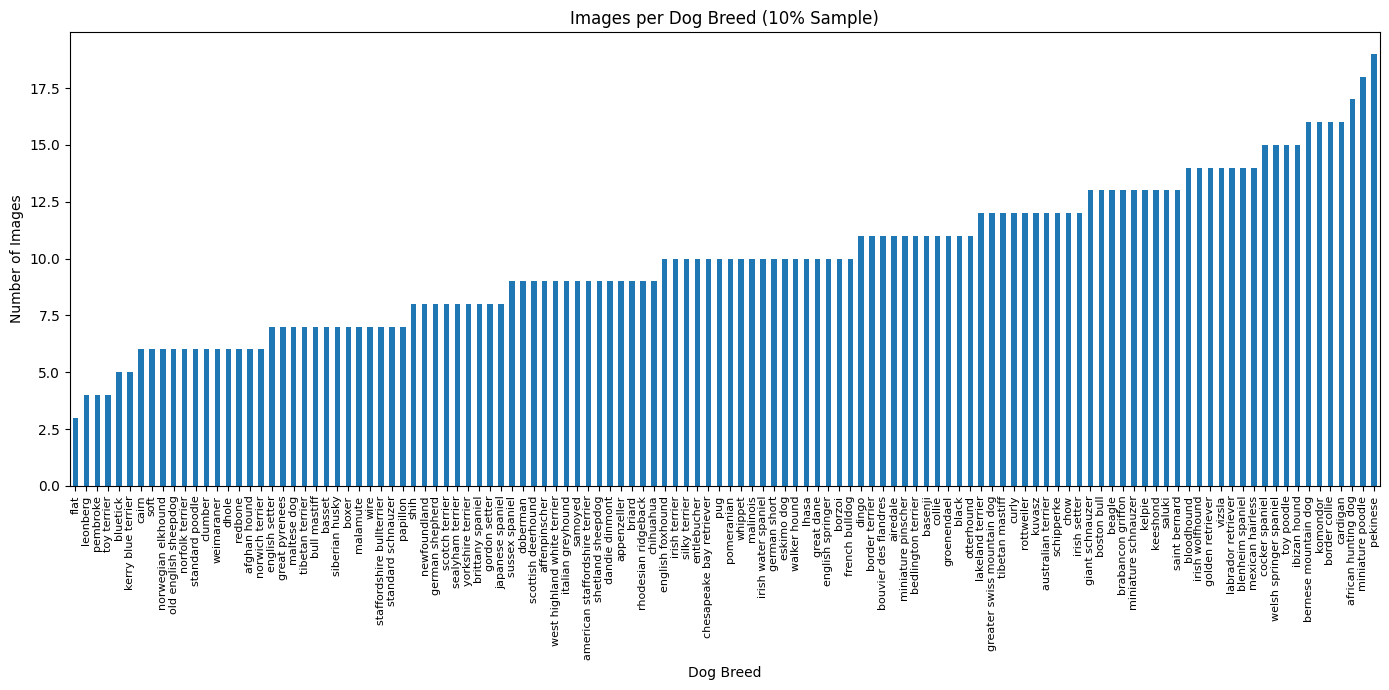

In [46]:
plt.figure(figsize=(14, 7))
train_10_percent_image_class_count_df.plot(kind="bar",
                                           x="class_name",
                                           y="image_count",
                                           legend=False,
                                           ax=plt.gca())

plt.title("Images per Dog Breed (10% Sample)")
plt.xlabel("Dog Breed")
plt.ylabel("Number of Images")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()
#